# Comparison between with and without offset model

Loaded astroNN model, model type: Bayesian Convolutional Neural Network -> ApogeeBCNN
Starting Dropout Variational Inference
Completed Dropout Variational Inference with 100 forward passes, 116.91s elapsed
Loaded astroNN model, model type: Bayesian Convolutional Neural Network -> ApogeeBCNN
Starting Dropout Variational Inference
Completed Dropout Variational Inference with 100 forward passes, 115.05s elapsed


C:\Users\Henry\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Henry\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


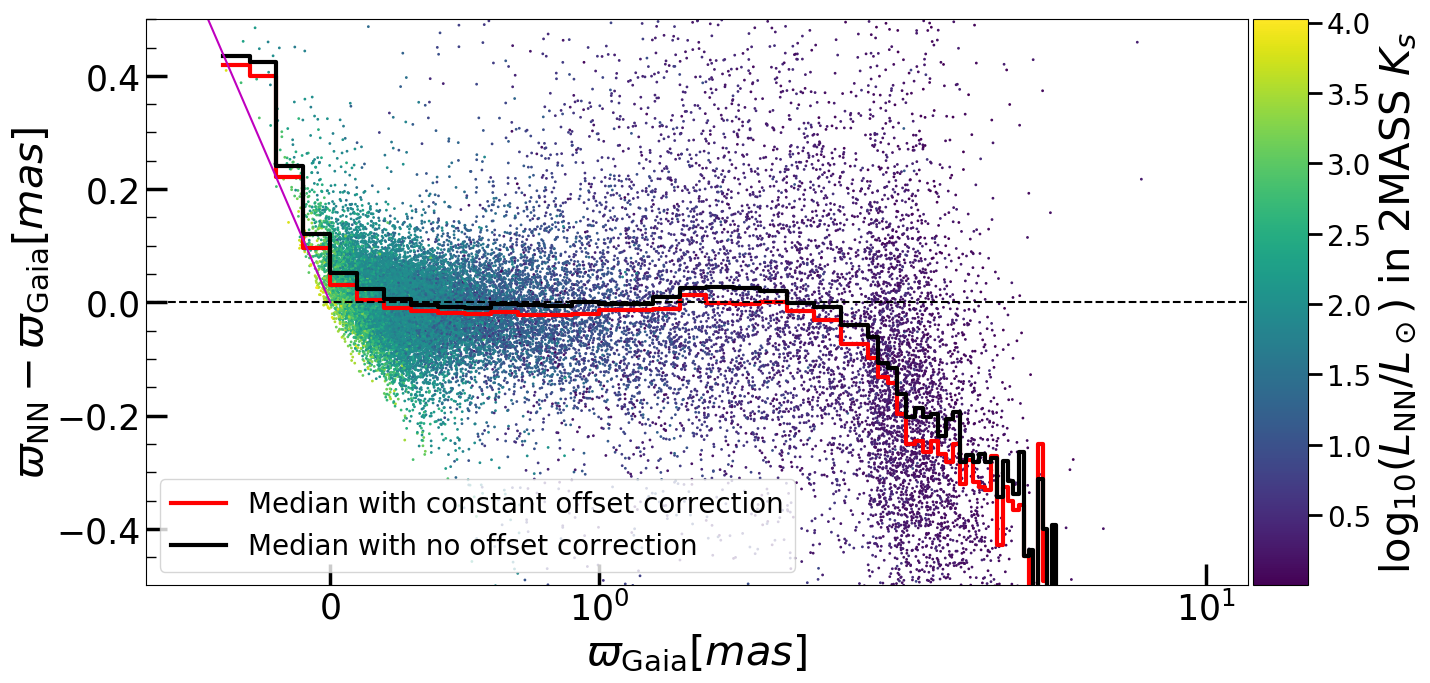

In [1]:
%matplotlib inline
from astroNN.models import load_folder
from astroNN.nn.numpy import median_absolute_percentage_error as mape
from astroNN.gaia import mag_to_fakemag, fakemag_to_pc, fakemag_to_logsol, fakemag_to_parallax
import h5py
import numpy as np
import pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

with h5py.File('gaia_dr2_test.h5', 'r') as F:
    spectra = np.array(F['spectra'])
    parallax = np.array(F['parallax'])
    parallax_err = np.array(F['parallax_err'])
    corrected_K = np.array(F['corrected_K'])
    
net = load_folder("astroNN_constant_model_reduced")
pred, pred_error = net.test(spectra)

net2 = load_folder("astroNN_no_offset_model")
pred2, pred2_error = net2.test(spectra)

logsol = fakemag_to_logsol(pred[:, 0])

above_solar = (logsol > 0)

number_bin = 55
low_parallax = -0.5
high_parallax= 5
median_diff = []
median_diff2 = []
spaces_dist = np.linspace(low_parallax, high_parallax, number_bin+1)

residue = (fakemag_to_parallax(pred[:, 0], corrected_K).value - parallax - 0.052)[above_solar]
residue2 = (fakemag_to_parallax(pred2[:, 0], corrected_K).value - parallax)[above_solar]

for i in range(number_bin):
    idx = ((parallax[above_solar]<spaces_dist[i+1]) & (parallax[above_solar]>spaces_dist[i]))
    median_diff.append(np.median(residue[idx]))
    median_diff2.append(np.median(residue2[idx]))

f, ax = plt.subplots(1, figsize=(15,7.5), dpi=100)
ax.semilogx(spaces_dist[:-1], np.array(median_diff), ls='steps-post', linewidth=3., c='r', label='Median with constant offset correction')
ax.semilogx(spaces_dist[:-1], np.array(median_diff2), ls='steps-post', linewidth=3., c='k', label='Median with no offset correction')
mappable = ax.scatter(parallax[above_solar], residue, c=logsol[above_solar], s=1., rasterized=True)
ax.set_xscale('symlog')
ax.axhline(0., ls='--', c='k')
ax.plot([0, -0.5], [0.0, 0.55], c='m')
ax.set_xlabel(r'$ \varpi_{\mathrm{Gaia}} [mas]$', fontsize=30)
ax.set_ylabel(r'$\varpi_{\mathrm{NN}} - \varpi_{\mathrm{Gaia}} [mas]$', fontsize=30)
ax.set_ylim(-0.5, 0.5)
ax.legend(loc='best', fontsize=20)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mappable, cax=cax)
cbar.ax.tick_params(labelsize=25 * 0.8, width=20 / 10, length=20 / 2)
cbar.set_label(r"$\log_{10} (L_\mathrm{NN} /L_\odot)$" + " in 2MASS " + r"$K_{s}$", size=30)
ax.minorticks_on()
ax.tick_params(labelsize=25, width=2.5, length=15, which='major')
ax.tick_params(width=1, length=7, which='minor')
ax.xaxis.set_tick_params(direction='in', which='both')
ax.yaxis.set_tick_params(direction='in', which='both')
# plt.savefig("result_offset_median.pdf")

# Get constant offset model posterior

Getting posterior from offset model is not trivial and the following code shows how to do it.

The offset we print follow the following equation
> Gaia parallax = True parallax + offset

**restart your ipython kernel everytime you run it**

In [1]:
import numpy as np

from astroNN.models import load_folder
from astroNN.config import keras_import_manager, cpu_gpu_check

cpu_gpu_check()  # manage GPU memory with astroNN if neccessary, otherwise use CPU
keras = keras_import_manager()  # manage Keras import with astroNN according to astroNN's config.ini
Model = keras.models.Model

net = load_folder("astroNN_constant_model")
# create new model to get offset posterior
model = Model(inputs=net.keras_model.input, outputs=net.get_layer("offset_output").output)

# To get offset posterior
offset = model.predict({'input': np.ones((1000, 7518, 1)), 'labels_err': np.ones((1000, 1)), 
                        'input_err': np.ones((1000, 7518, 1))}) * 1.4124689064768827 * 1000
mean, std = np.mean(offset), np.std(offset)
print(f"Offset: {mean:.1f}+/-{std:.1f}")

Loaded astroNN model, model type: Bayesian Convolutional Neural Network -> ApogeeDR14GaiaDR2BCNN
Offset: -52.3+/-2.0


# Get multivariate offset model posterior

Getting posterior from offset model is not trivial just by using ``astroNN`` and the following code shows how to do it, sampling 10 times

The offset we print follow the following equation
> Gaia parallax = True parallax + offset

**restart your ipython kernel everytime you run it**

Loaded astroNN model, model type: Bayesian Convolutional Neural Network -> ApogeeDR14GaiaDR2BCNN
DP_RP:  [ -2.96172182 -44.47221099] [0.0016983  0.00486159]
G mag:  [ -2.39806501 -15.25517257] [0.00035571 0.07199601]
T_eff:  [ 7.62002778e-03 -8.57772446e+01] [6.27438740e-09 1.43988995e-01]

Plane fit parameter:  [ -2.85475017   1.17187621 -10.68425129]
Parameter uncertainty:  [5.19217587e-05 1.92918722e-04 7.51402048e-03]


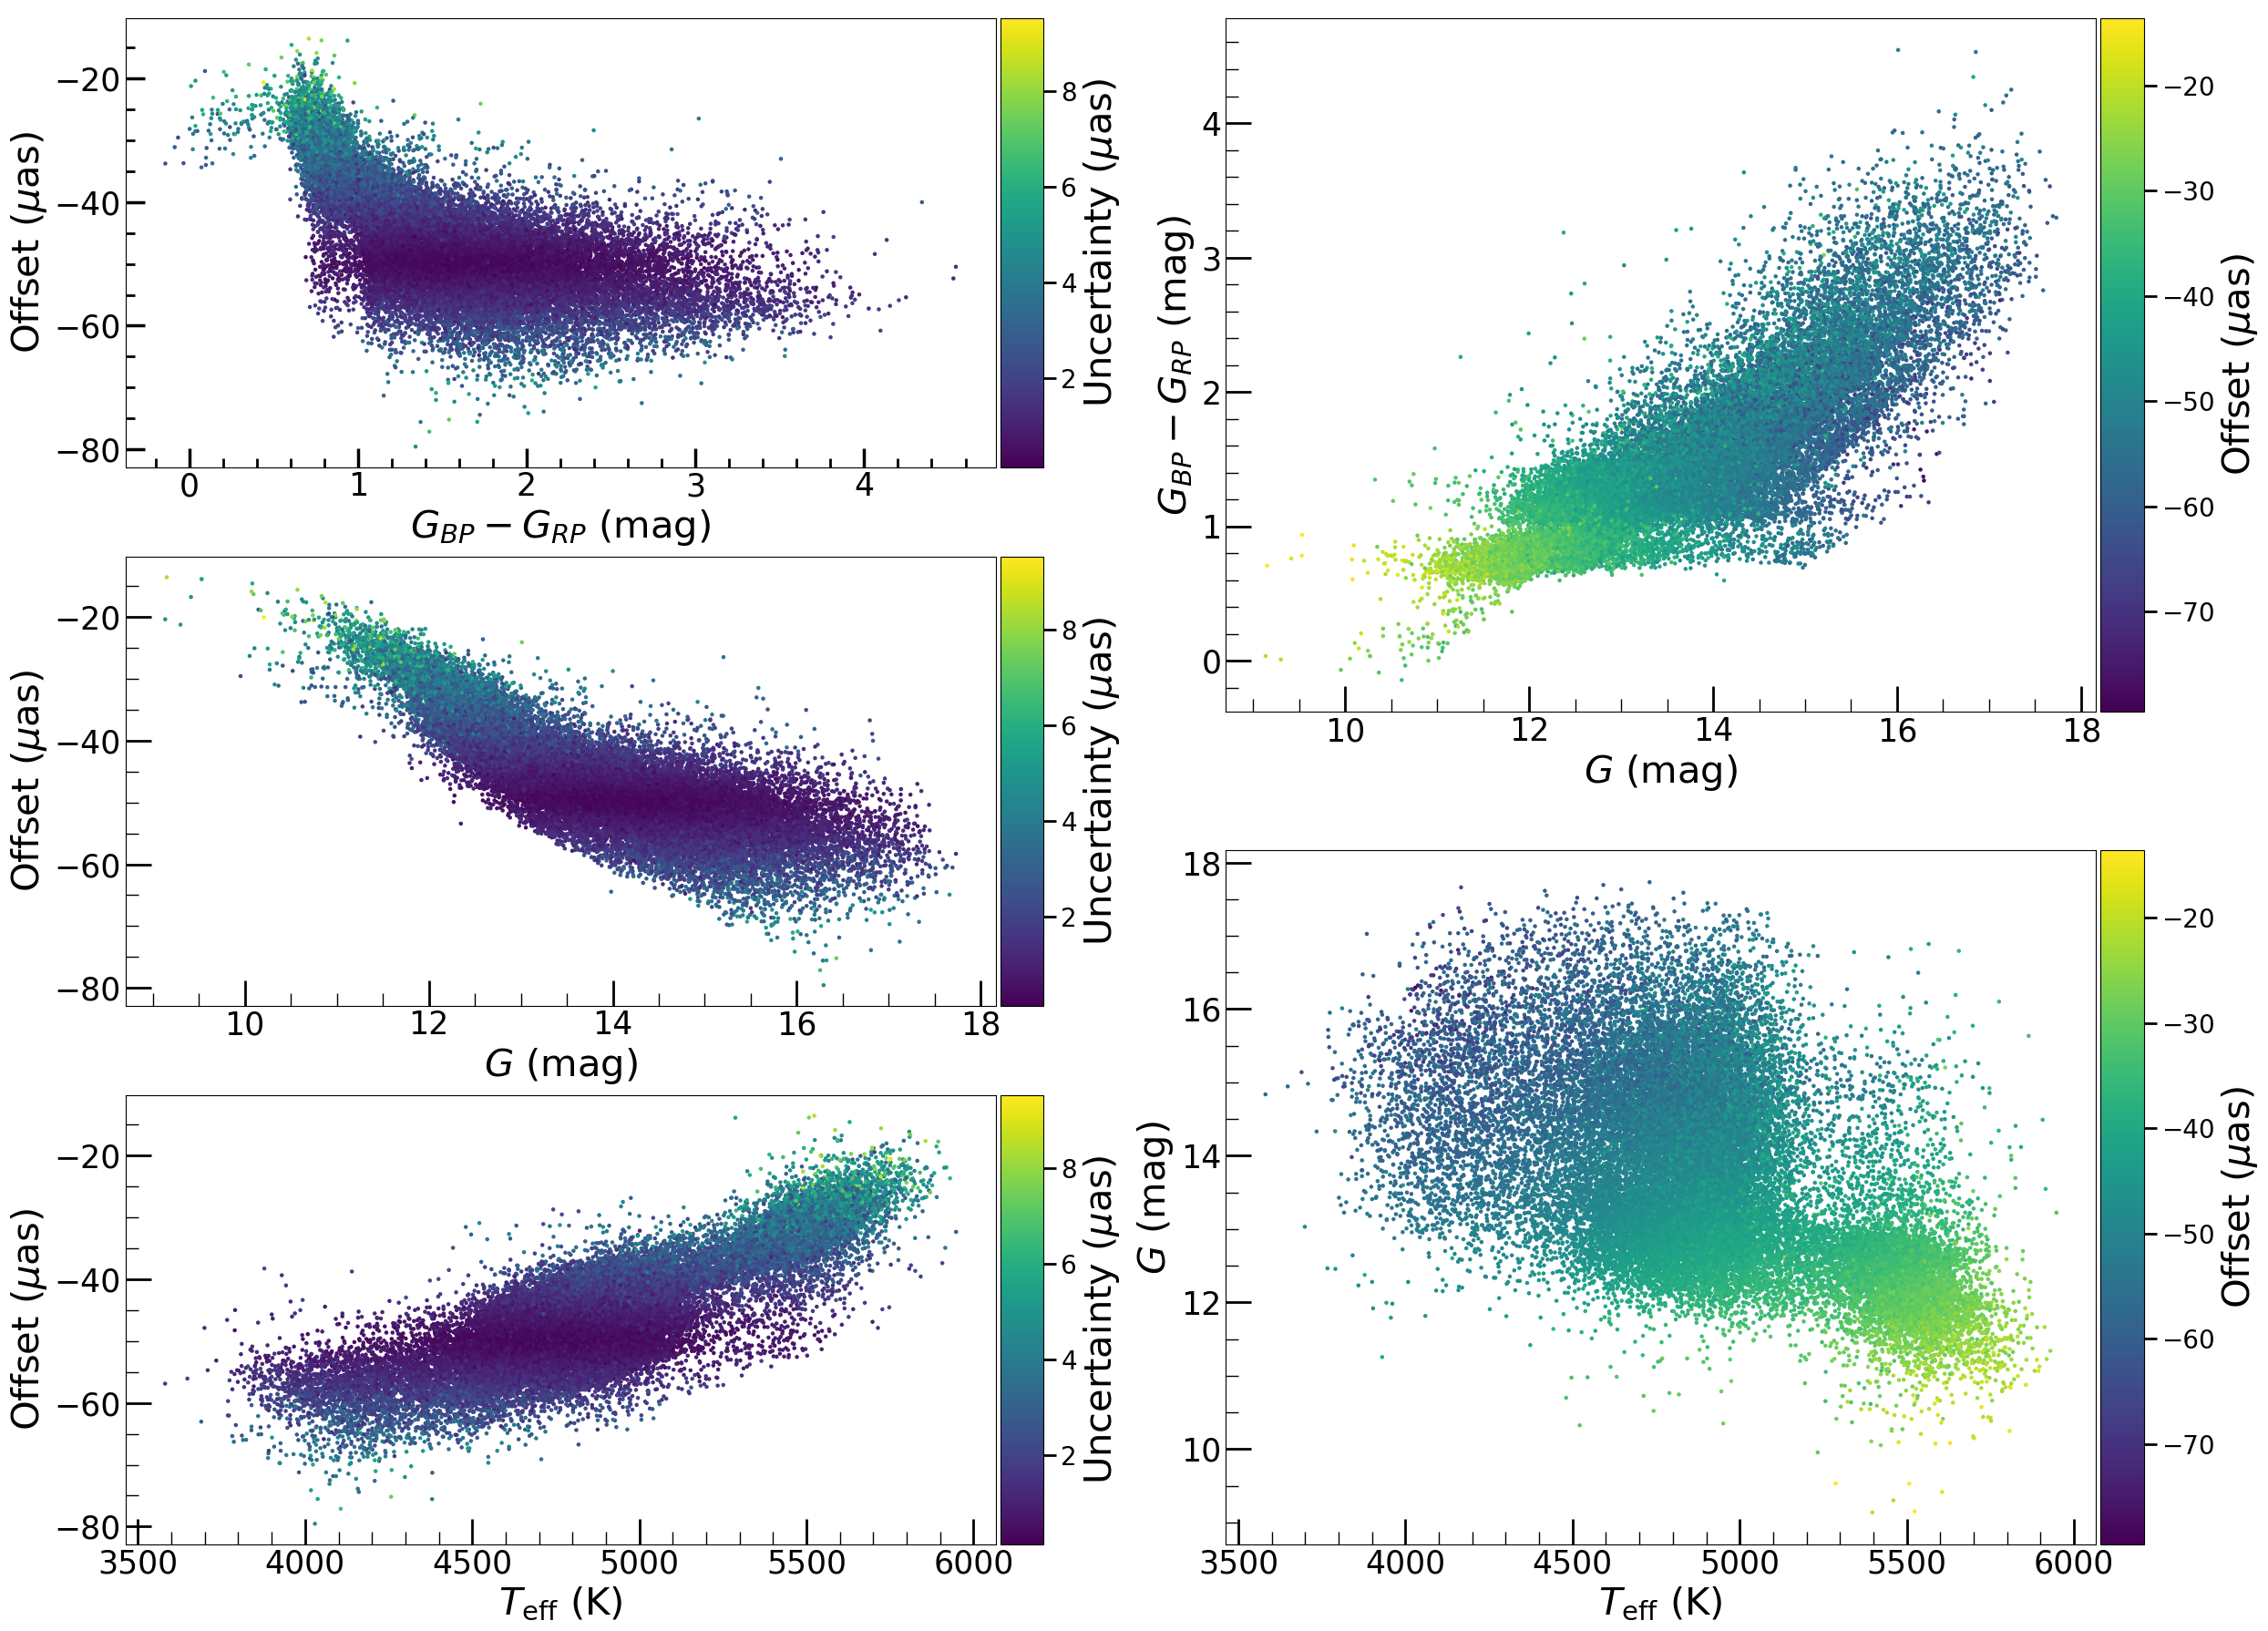

In [2]:
%matplotlib inline
import h5py
import numpy as np
import pylab as plt
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import NullFormatter,MultipleLocator, FormatStrFormatter

from astroNN.models import load_folder
from astroNN.config import keras_import_manager, cpu_gpu_check

cpu_gpu_check()  # manage GPU memory with astroNN if neccessary, otherwise use CPU
keras = keras_import_manager()  # manage Keras import with astroNN according to astroNN's config.ini
Model = keras.models.Model

net = load_folder("astroNN_multivariate_model")
# create new model to get offset posterior
model = Model(inputs=net.keras_model.input, outputs=net.get_layer("offset_output").output)

with h5py.File('gaia_dr2_test.h5') as F:  # ensure the file will be cleaned up
    bp_rp = np.array(F['bp_rp'])
    phot_g_mean_mag = np.array(F['phot_g_mean_mag'])
    teff = np.array(F['NN_teff'])

    good_idx = ((bp_rp != -9999.) & (phot_g_mean_mag != -9999.)  & (teff != -9999.))

    bp_rp = bp_rp[good_idx]
    phot_g_mean_mag = phot_g_mean_mag[good_idx]
    teff = teff[good_idx]

# need to manually 
phot_g_mean_mag_std = np.std(phot_g_mean_mag)
phot_g_mean_mag_mean = np.mean(phot_g_mean_mag)
norm_phot_g_mean_mag = (phot_g_mean_mag - phot_g_mean_mag_mean) / phot_g_mean_mag_std

bp_rp_std = np.std(bp_rp)
bp_rp_mean = np.mean(bp_rp)
norm_bp_rp = (bp_rp - bp_rp_mean) / bp_rp_std

teff_std = np.std(teff)
teff_mean = np.mean(teff)
norm_teff = (teff - teff_mean) / teff_std

aux = np.stack([norm_phot_g_mean_mag, norm_bp_rp, norm_teff]).T

# To get offset posterior, sample 10 times
offset = [model.predict({'input': np.expand_dims(np.hstack([np.ones((norm_teff.shape[0], 7515)), aux]), axis=-1), 
                         'labels_err': np.ones((norm_teff.shape[0], 1)), 
                         'input_err': np.ones((norm_teff.shape[0], 7518, 1))}) * 1.4125440212222566 * 1000 for i in range(10)]
# get result and uncertainty by dropout
result, offset_uncertainty = np.mean(offset, axis=0)[:, 0], np.std(offset, axis=0)[:, 0]

fig = plt.figure(figsize=(25, 18), dpi=100)
gs = gridspec.GridSpec(1, 2)
inner1 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[0])
inner2 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1])

ax0 = plt.Subplot(fig, inner1[0])
ax1 = plt.Subplot(fig, inner1[1])
ax2 = plt.Subplot(fig, inner1[2])
ax3 = plt.Subplot(fig, inner2[0])
ax4 = plt.Subplot(fig, inner2[1])

mappable = ax0.scatter(bp_rp, result, c=offset_uncertainty, s=5., rasterized=True)
ax0.set_xlabel(r"$G_{BP}-G_{RP}$ (mag)", fontsize=30)
ax0.set_ylabel(r"Offset ($\mu$as)", fontsize=30)
ax0.minorticks_on()
ax0.tick_params(labelsize=25, width=2.5, length=15, which='major')
ax0.tick_params(width=2, length=7, which='minor')
ax0.xaxis.set_tick_params(direction='in', which='both')
ax0.yaxis.set_tick_params(direction='in', which='both')
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mappable, cax=cax)
cbar.ax.tick_params(labelsize=25 * 0.8, width=20 / 10, length=20 / 2)
cbar.set_label(r"Uncertainty ($\mu$as)", size=30)

mappable = ax1.scatter(phot_g_mean_mag, result, c=offset_uncertainty, s=5., rasterized=True)
ax1.set_xlabel(r"$G$ (mag)", fontsize=30)
ax1.set_ylabel(r"Offset ($\mu$as)", fontsize=30)
ax1.minorticks_on()
ax1.tick_params(labelsize=25, width=2, length=20, which='major')
ax1.tick_params(width=1, length=10, which='minor')
ax1.xaxis.set_tick_params(direction='in', which='both')
ax1.yaxis.set_tick_params(direction='in', which='both')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mappable, cax=cax)
cbar.ax.tick_params(labelsize=25 * 0.8, width=20 / 10, length=20 / 2)
cbar.set_label(r"Uncertainty ($\mu$as)", size=30)

mappable = ax2.scatter(teff, result, c=offset_uncertainty, s=5., rasterized=True)
ax2.set_xlabel(r"$T_\mathrm{eff}$ (K)", fontsize=30)
ax2.set_ylabel(r"Offset ($\mu$as)", fontsize=30)
ax2.minorticks_on()
ax2.tick_params(labelsize=25, width=2, length=20, which='major')
ax2.tick_params(width=1, length=10, which='minor')
ax2.xaxis.set_tick_params(direction='in', which='both')
ax2.yaxis.set_tick_params(direction='in', which='both')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mappable, cax=cax)
cbar.ax.tick_params(labelsize=25 * 0.8, width=20 / 10, length=20 / 2)
cbar.set_label(r"Uncertainty ($\mu$as)", size=30)

mappable = ax3.scatter(phot_g_mean_mag, bp_rp, c=result, s=5., rasterized=True)
ax3.set_xlabel(r"$G$ (mag)", fontsize=30)
ax3.set_ylabel(r"$G_{BP}-G_{RP}$ (mag)", fontsize=30)
ax3.minorticks_on()
ax3.tick_params(labelsize=25, width=2, length=20, which='major')
ax3.tick_params(width=1, length=10, which='minor')
ax3.xaxis.set_tick_params(direction='in', which='both')
ax3.yaxis.set_tick_params(direction='in', which='both')
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mappable, cax=cax)
cbar.ax.tick_params(labelsize=25 * 0.8, width=20 / 10, length=20 / 2)
cbar.set_label(r"Offset ($\mu$as)", size=30)

mappable = ax4.scatter(teff, phot_g_mean_mag, c=result, s=5., rasterized=True)
ax4.set_xlabel(r"$T_\mathrm{eff}$ (K)", fontsize=30)
ax4.set_ylabel(r"$G$ (mag)", fontsize=30)
ax4.minorticks_on()
ax4.tick_params(labelsize=25, width=2, length=20, which='major')
ax4.tick_params(width=1, length=10, which='minor')
ax4.xaxis.set_tick_params(direction='in', which='both')
ax4.yaxis.set_tick_params(direction='in', which='both')
divider = make_axes_locatable(ax4)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mappable, cax=cax)
cbar.ax.tick_params(labelsize=25 * 0.8, width=20 / 10, length=20 / 2)
cbar.set_label(r"Offset ($\mu$as)", size=30)

fig.add_subplot(ax0)
fig.add_subplot(ax1)
fig.add_subplot(ax2)
fig.add_subplot(ax3)
fig.add_subplot(ax4)

fig.tight_layout()
plt.savefig("result_offset.pdf")

z_bp_rp, cov_bp_rp = np.polyfit(bp_rp, result, deg=1, w=1/offset_uncertainty, full=False, cov=True)
z_g, cov_g = np.polyfit(phot_g_mean_mag, result, deg=1, w=1/offset_uncertainty, full=False, cov=True)
z_teff, cov_teff = np.polyfit(teff, result, deg=1, w=1/offset_uncertainty, full=False, cov=True)

pall, pall_cov = curve_fit(lambda x, a, b, c: a*x[0] + b*x[1] + c, (phot_g_mean_mag, bp_rp), result, sigma=offset_uncertainty,
                          absolute_sigma=True)

print("DP_RP: ", z_bp_rp, np.diag(cov_bp_rp))
print("G mag: ", z_g, np.diag(cov_g))
print("T_eff: ", z_teff, np.diag(cov_teff))

print("\nPlane fit parameter: ", pall)
print("Parameter uncertainty: ", np.diag(pall_cov))